In [3]:
import numpy as np
import scipy.stats as ss
from scipy.stats import entropy
from scipy.integrate import quad
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

In [4]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
#path_to_data = "C:\\Users\\Admin\\Dropbox\\AppliedCognitiveModelling2017\\ABC\\03 data"

In [48]:
def plot_for_report(
    list_of_sampler, 
    posterior=None, 
    posterior_mean = None,
    posterior_label = "reference posterior",
    legend_text=None,
    title_text=None, 
    xlabel=None, 
    ylabel=None, 
    savefig=False, 
    figname=None,
    no_spines = ["top", "bottom", "right", "left"],
    mark_means = True,
    calc_kl = False,
    plot_hist = False,
    **kw_hist
):
    """plot kde for each sampler and true posterior if available"""
    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 


    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)  
    
    # plot for report
    # You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
    # exception because of the number of lines being plotted on it.    
    # Common sizes: (10, 7.5) and (12, 9)    
    plt.figure(figsize=(10, 7.5)) 

    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    for spine in no_spines:
        ax.spines[spine].set_visible(False)
        
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.tick_params(axis='both', which='major', pad=15)

    #plot ABC posterior
    #xx = np.linspace(mu_0 - 3*sigma_0, mu_0 + 4*sigma_0, 200)
    x_min = np.inf
    x_max = -np.inf
    for i, sampler in enumerate(list_of_sampler):
        thetas = sampler.Thetas.flatten()
        xx = np.linspace(np.min(thetas) - 0.1, np.max(thetas) + 0.1, 200)
        if x_min > np.min(xx):
            x_min = np.min(xx)
        if x_max < np.max(xx):
            x_max = np.max(xx)
            
        # plot posterior
        #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
        # plot KDE and MAP
        # get the bandwidth method argument for scipy
        # and run scipy's kde
        kde = ss.kde.gaussian_kde(thetas)
        dens = kde(xx)
        if legend_text is not None:
            plt.plot(xx, dens, color=tableau20[i*2], label=legend_text[i])
        else:
            plt.plot(xx, dens, color=tableau20[i*2])
        
        if plot_hist:
            plt.hist(thetas, normed=True, color=tableau20[i*2], **kw_hist)
        
        #mark means
        if mark_means:
            mean = np.mean(thetas)
            plt.plot(mean, 0, color=tableau20[i*2], marker="D")

    # plot ground truth posterior
    kl = []
    if posterior is not None:
        xx = np.linspace(x_min, x_max, 200)
        yy = posterior(xx)
        plt.plot(xx, yy, "m", label=posterior_label, linewidth=3, color="m")
        
        if mark_means:
            if posterior_mean is None:
                if mark_means:
                    mean, err = quad(lambda x : x * posterior(x), x_min-1, x_max+1)
                    print("posterior mean:", mean, "with error", err)
                    # find closest x
                    plt.plot(mean, 0, color="m", marker="D")
            else:
                plt.plot(posterior_mean, 0, color="m", marker="D")
                print("posterior mean:", posterior_mean)
            
        # calculate kullback leibler divergence
        if calc_kl:
            for i, sampler in enumerate(list_of_sampler):
                thetas = sampler.Thetas.flatten()
            
                # plot posterior
                #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
                # plot KDE and MAP
                # get the bandwidth method argument for scipy
                # and run scipy's kde
                kde = ss.kde.gaussian_kde(thetas)
                kl.append(
                    entropy(
                        np.where(kde(xx) < 1e-50, 1e-50, kde(xx)),
                        np.where(posterior(xx) < 1e-50, 1e-50, posterior(xx))
                    )
                )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r"$\theta$")
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(r"$p(\theta|D)$")
    
    if title_text is not None:
        plt.title(title_text)
        
    plt.legend(fontsize=14)
    plt.gca().set_ylim(bottom=-0.1)
    
    if savefig:
        plt.savefig(figname, bbox_inches='tight')
        
    return kl

<IPython.core.display.Javascript object>


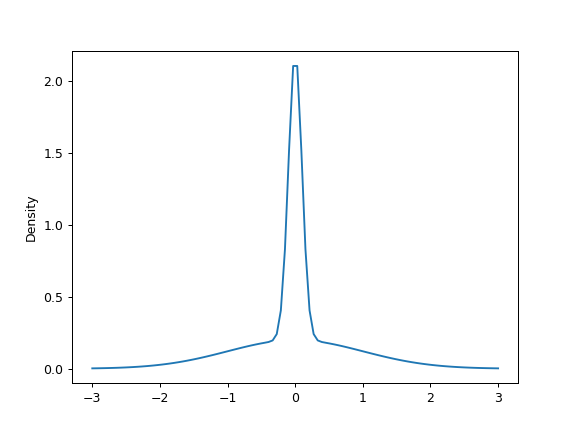

In [7]:
prior = pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

def simulator(mu):
    return np.random.normal(mu, 1, size=100)

summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, np.sqrt(0.01))

y0 = np.array([0.])

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.ylabel("Density")
plt.show()

In [8]:
rej = pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0, verbosity=2)

In [10]:
rej.sample(nr_samples=10000, threshold=0.01)
rej.save(os.path.join(path_to_data, "ex03", "rej_10000_0_01.npy"))

Rejection sampler started with threshold: 0.01 and number of samples: 10000
Samples:      0 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       1000 - Acceptance rate: 0.000000 - Time:     0.05 s
Samples:      1 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       2000 - Acceptance rate: 0.000500 - Time:     0.09 s
Samples:      1 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       3000 - Acceptance rate: 0.000333 - Time:     0.11 s
Samples:      3 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       4000 - Acceptance rate: 0.000750 - Time:     0.14 s
Samples:      5 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       5000 - Acceptance rate: 0.001000 - Time:     0.16 s
Samples:      6 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       6000 - Acceptance rate: 0.001000 - Time:     0.19 s
Samples:      6 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       7000 - Acceptance rate: 0.000857 - Time:     0.22 s
Samples:      7 /  10000 (  0 %)- Threshold: 0.0100 - It

Samples:     64 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      68000 - Acceptance rate: 0.000941 - Time:     1.76 s
Samples:     65 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      69000 - Acceptance rate: 0.000942 - Time:     1.79 s
Samples:     66 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      70000 - Acceptance rate: 0.000943 - Time:     1.82 s
Samples:     68 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      71000 - Acceptance rate: 0.000958 - Time:     1.85 s
Samples:     69 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      72000 - Acceptance rate: 0.000958 - Time:     1.87 s
Samples:     72 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      73000 - Acceptance rate: 0.000986 - Time:     1.89 s
Samples:     75 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      74000 - Acceptance rate: 0.001014 - Time:     1.92 s
Samples:     76 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:      75000 - Acceptance rate: 0.001013 - Time:     1.94 s
Samples:

Samples:    139 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     136000 - Acceptance rate: 0.001022 - Time:     3.51 s
Samples:    141 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     137000 - Acceptance rate: 0.001029 - Time:     3.54 s
Samples:    142 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     138000 - Acceptance rate: 0.001029 - Time:     3.56 s
Samples:    143 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     139000 - Acceptance rate: 0.001029 - Time:     3.59 s
Samples:    146 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     140000 - Acceptance rate: 0.001043 - Time:     3.61 s
Samples:    148 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     141000 - Acceptance rate: 0.001050 - Time:     3.64 s
Samples:    148 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     142000 - Acceptance rate: 0.001042 - Time:     3.67 s
Samples:    148 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     143000 - Acceptance rate: 0.001035 - Time:     3.70 s
Samples:

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


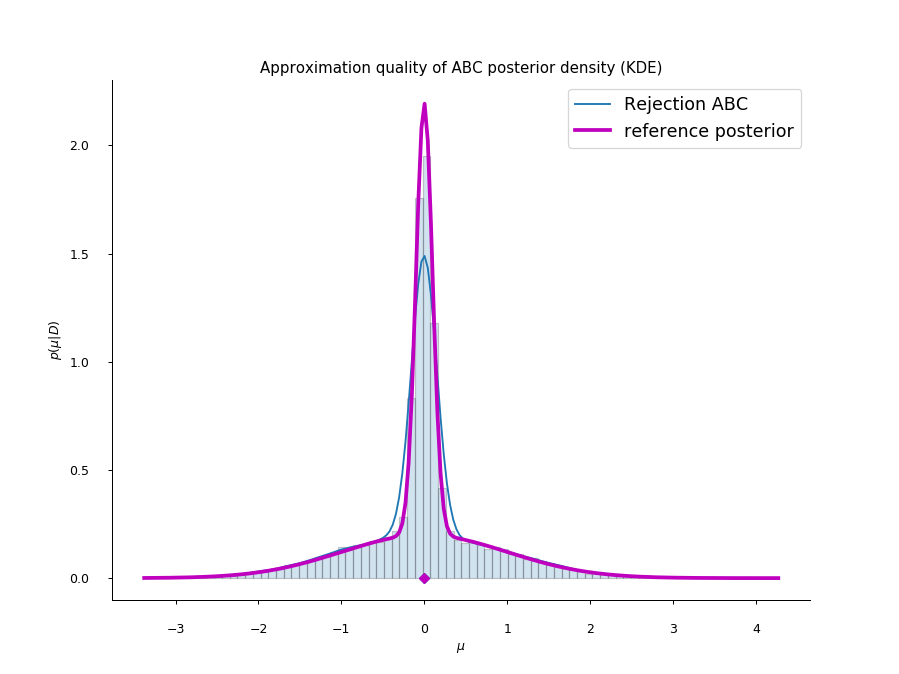

posterior mean: 0


[0.039982250298680626]

In [49]:
rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex03", "rej_10000_0_01.npy"))

legend = ["Rejection ABC"]

plot_for_report(
    list_of_sampler = [rej], 
    posterior=posterior, 
    posterior_mean=0,
    legend_text=legend, 
    title_text="Approximation quality of ABC posterior density (KDE)", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex03_rej_abc.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True,
    plot_hist=True,
    bins=80,
    edgecolor="k",
    alpha=0.2
)


In [52]:
rej.nr_iter

9952000

In [53]:
abs(0 - rej.Thetas.mean())

0.0067338391113136165

In [64]:
mcmc = pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                         summaries=[summary], distance=rho,
                         observation=y0, verbosity=2)

In [65]:
mcmc.sample(nr_samples=10000, threshold=0.01, step_size=[0.15**2])
mcmc.save(os.path.join(path_to_data, "ex03", "mcmc_10000_0_01_0_15.npy"))

MCMC sampler started with threshold: 0.01 and number of samples: 10000
Samples:     10 - Threshold: 0.0100 - Iterations:      13770 - Acceptance rate: 0.000726 - Time:     0.57 s
Samples:     45 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       2000 - Acceptance rate: 5.000000 - Time:     1.08 s
Samples:     67 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       3000 - Acceptance rate: 3.333333 - Time:     1.35 s
Samples:     79 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       4000 - Acceptance rate: 2.500000 - Time:     1.60 s
Samples:     99 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       5000 - Acceptance rate: 2.000000 - Time:     1.86 s
Samples:    110 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       6000 - Acceptance rate: 1.666667 - Time:     2.12 s
Samples:    135 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       7000 - Acceptance rate: 1.428571 - Time:     2.40 s
Samples:    165 /  10000 (  2 %)- Threshold: 0.0100 - Iterations:       8000 

Samples:   1390 /  10000 ( 14 %)- Threshold: 0.0100 - Iterations:      70000 - Acceptance rate: 0.142857 - Time:    20.58 s
Samples:   1400 /  10000 ( 14 %)- Threshold: 0.0100 - Iterations:      71000 - Acceptance rate: 0.140845 - Time:    20.91 s
Samples:   1404 /  10000 ( 14 %)- Threshold: 0.0100 - Iterations:      72000 - Acceptance rate: 0.138889 - Time:    21.22 s
Samples:   1422 /  10000 ( 14 %)- Threshold: 0.0100 - Iterations:      73000 - Acceptance rate: 0.136986 - Time:    21.53 s
Samples:   1443 /  10000 ( 14 %)- Threshold: 0.0100 - Iterations:      74000 - Acceptance rate: 0.135135 - Time:    21.84 s
Samples:   1467 /  10000 ( 15 %)- Threshold: 0.0100 - Iterations:      75000 - Acceptance rate: 0.133333 - Time:    22.21 s
Samples:   1478 /  10000 ( 15 %)- Threshold: 0.0100 - Iterations:      76000 - Acceptance rate: 0.131579 - Time:    22.56 s
Samples:   1483 /  10000 ( 15 %)- Threshold: 0.0100 - Iterations:      77000 - Acceptance rate: 0.129870 - Time:    22.92 s
Samples:

Samples:   2710 /  10000 ( 27 %)- Threshold: 0.0100 - Iterations:     139000 - Acceptance rate: 0.071942 - Time:    43.81 s
Samples:   2728 /  10000 ( 27 %)- Threshold: 0.0100 - Iterations:     140000 - Acceptance rate: 0.071429 - Time:    44.11 s
Samples:   2752 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     141000 - Acceptance rate: 0.070922 - Time:    44.41 s
Samples:   2762 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     142000 - Acceptance rate: 0.070423 - Time:    44.82 s
Samples:   2782 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     143000 - Acceptance rate: 0.069930 - Time:    45.24 s
Samples:   2807 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     144000 - Acceptance rate: 0.069444 - Time:    45.59 s
Samples:   2822 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     145000 - Acceptance rate: 0.068966 - Time:    45.91 s
Samples:   2827 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     146000 - Acceptance rate: 0.068493 - Time:    46.23 s
Samples:

Samples:   3426 /  10000 ( 34 %)- Threshold: 0.0100 - Iterations:     207000 - Acceptance rate: 0.048309 - Time:    68.01 s
Samples:   3451 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     208000 - Acceptance rate: 0.048077 - Time:    68.36 s
Samples:   3472 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     209000 - Acceptance rate: 0.047847 - Time:    68.74 s
Samples:   3487 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     210000 - Acceptance rate: 0.047619 - Time:    69.05 s
Samples:   3504 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     211000 - Acceptance rate: 0.047393 - Time:    69.36 s
Samples:   3520 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     212000 - Acceptance rate: 0.047170 - Time:    69.74 s
Samples:   3526 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     213000 - Acceptance rate: 0.046948 - Time:    70.04 s
Samples:   3535 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     214000 - Acceptance rate: 0.046729 - Time:    70.33 s
Samples:

Samples:   4678 /  10000 ( 47 %)- Threshold: 0.0100 - Iterations:     275000 - Acceptance rate: 0.036364 - Time:    90.55 s
Samples:   4696 /  10000 ( 47 %)- Threshold: 0.0100 - Iterations:     276000 - Acceptance rate: 0.036232 - Time:    90.86 s
Samples:   4723 /  10000 ( 47 %)- Threshold: 0.0100 - Iterations:     277000 - Acceptance rate: 0.036101 - Time:    91.15 s
Samples:   4745 /  10000 ( 47 %)- Threshold: 0.0100 - Iterations:     278000 - Acceptance rate: 0.035971 - Time:    91.44 s
Samples:   4768 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     279000 - Acceptance rate: 0.035842 - Time:    91.73 s
Samples:   4779 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     280000 - Acceptance rate: 0.035714 - Time:    92.01 s
Samples:   4801 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     281000 - Acceptance rate: 0.035587 - Time:    92.29 s
Samples:   4817 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     282000 - Acceptance rate: 0.035461 - Time:    92.58 s
Samples:

Samples:   6173 /  10000 ( 62 %)- Threshold: 0.0100 - Iterations:     344000 - Acceptance rate: 0.029070 - Time:   110.94 s
Samples:   6199 /  10000 ( 62 %)- Threshold: 0.0100 - Iterations:     345000 - Acceptance rate: 0.028986 - Time:   111.22 s
Samples:   6221 /  10000 ( 62 %)- Threshold: 0.0100 - Iterations:     346000 - Acceptance rate: 0.028902 - Time:   111.52 s
Samples:   6251 /  10000 ( 63 %)- Threshold: 0.0100 - Iterations:     347000 - Acceptance rate: 0.028818 - Time:   111.81 s
Samples:   6271 /  10000 ( 63 %)- Threshold: 0.0100 - Iterations:     348000 - Acceptance rate: 0.028736 - Time:   112.10 s
Samples:   6296 /  10000 ( 63 %)- Threshold: 0.0100 - Iterations:     349000 - Acceptance rate: 0.028653 - Time:   112.40 s
Samples:   6317 /  10000 ( 63 %)- Threshold: 0.0100 - Iterations:     350000 - Acceptance rate: 0.028571 - Time:   112.69 s
Samples:   6340 /  10000 ( 63 %)- Threshold: 0.0100 - Iterations:     351000 - Acceptance rate: 0.028490 - Time:   112.98 s
Samples:

Samples:   7420 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:     412000 - Acceptance rate: 0.024272 - Time:   130.65 s
Samples:   7436 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:     413000 - Acceptance rate: 0.024213 - Time:   130.93 s
Samples:   7438 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:     414000 - Acceptance rate: 0.024155 - Time:   131.22 s
Samples:   7438 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:     415000 - Acceptance rate: 0.024096 - Time:   131.50 s
Samples:   7455 /  10000 ( 75 %)- Threshold: 0.0100 - Iterations:     416000 - Acceptance rate: 0.024038 - Time:   131.80 s
Samples:   7484 /  10000 ( 75 %)- Threshold: 0.0100 - Iterations:     417000 - Acceptance rate: 0.023981 - Time:   132.08 s
Samples:   7510 /  10000 ( 75 %)- Threshold: 0.0100 - Iterations:     418000 - Acceptance rate: 0.023923 - Time:   132.37 s
Samples:   7531 /  10000 ( 75 %)- Threshold: 0.0100 - Iterations:     419000 - Acceptance rate: 0.023866 - Time:   132.66 s
Samples:

Samples:   8338 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     480000 - Acceptance rate: 0.020833 - Time:   150.29 s
Samples:   8338 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     481000 - Acceptance rate: 0.020790 - Time:   150.57 s
Samples:   8338 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     482000 - Acceptance rate: 0.020747 - Time:   150.85 s
Samples:   8338 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     483000 - Acceptance rate: 0.020704 - Time:   151.13 s
Samples:   8339 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     484000 - Acceptance rate: 0.020661 - Time:   151.41 s
Samples:   8339 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     485000 - Acceptance rate: 0.020619 - Time:   151.70 s
Samples:   8339 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     486000 - Acceptance rate: 0.020576 - Time:   151.97 s
Samples:   8339 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     487000 - Acceptance rate: 0.020534 - Time:   152.26 s
Samples:

Samples:   8971 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:     548000 - Acceptance rate: 0.018248 - Time:   169.80 s
Samples:   8997 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:     549000 - Acceptance rate: 0.018215 - Time:   170.08 s
Samples:   9024 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:     550000 - Acceptance rate: 0.018182 - Time:   170.37 s
Samples:   9048 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:     551000 - Acceptance rate: 0.018149 - Time:   170.66 s
Samples:   9071 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:     552000 - Acceptance rate: 0.018116 - Time:   170.95 s
Samples:   9083 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:     553000 - Acceptance rate: 0.018083 - Time:   171.24 s
Samples:   9105 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:     554000 - Acceptance rate: 0.018051 - Time:   171.52 s
Samples:   9125 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:     555000 - Acceptance rate: 0.018018 - Time:   171.82 s
Samples:

In [66]:
mcmc.sample(nr_samples=10000, threshold=0.01, step_size=[0.5**2])
mcmc.save(os.path.join(path_to_data, "ex03", "mcmc_10000_0_01_0_5.npy"))

MCMC sampler started with threshold: 0.01 and number of samples: 10000
Samples:     10 - Threshold: 0.0100 - Iterations:       9470 - Acceptance rate: 0.001056 - Time:     0.67 s
Samples:     14 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       1000 - Acceptance rate: 10.000000 - Time:     1.09 s
Samples:     21 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       2000 - Acceptance rate: 5.000000 - Time:     1.42 s
Samples:     30 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       3000 - Acceptance rate: 3.333333 - Time:     1.74 s
Samples:     31 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       4000 - Acceptance rate: 2.500000 - Time:     2.04 s
Samples:     33 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       5000 - Acceptance rate: 2.000000 - Time:     2.34 s
Samples:     42 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:       6000 - Acceptance rate: 1.666667 - Time:     2.65 s
Samples:     59 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:       7000

Samples:    616 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:      66000 - Acceptance rate: 0.151515 - Time:    22.16 s
Samples:    619 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:      67000 - Acceptance rate: 0.149254 - Time:    22.63 s
Samples:    632 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:      68000 - Acceptance rate: 0.147059 - Time:    23.11 s
Samples:    638 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:      69000 - Acceptance rate: 0.144928 - Time:    23.48 s
Samples:    646 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:      70000 - Acceptance rate: 0.142857 - Time:    23.95 s
Samples:    667 /  10000 (  7 %)- Threshold: 0.0100 - Iterations:      71000 - Acceptance rate: 0.140845 - Time:    24.31 s
Samples:    679 /  10000 (  7 %)- Threshold: 0.0100 - Iterations:      72000 - Acceptance rate: 0.138889 - Time:    24.66 s
Samples:    694 /  10000 (  7 %)- Threshold: 0.0100 - Iterations:      73000 - Acceptance rate: 0.136986 - Time:    24.98 s
Samples:

Samples:   1251 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     133000 - Acceptance rate: 0.075188 - Time:    43.44 s
Samples:   1251 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     134000 - Acceptance rate: 0.074627 - Time:    43.74 s
Samples:   1258 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     135000 - Acceptance rate: 0.074074 - Time:    44.03 s
Samples:   1260 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     136000 - Acceptance rate: 0.073529 - Time:    44.32 s
Samples:   1270 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     137000 - Acceptance rate: 0.072993 - Time:    44.62 s
Samples:   1274 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     138000 - Acceptance rate: 0.072464 - Time:    44.92 s
Samples:   1281 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     139000 - Acceptance rate: 0.071942 - Time:    45.23 s
Samples:   1296 /  10000 ( 13 %)- Threshold: 0.0100 - Iterations:     140000 - Acceptance rate: 0.071429 - Time:    45.53 s
Samples:

Samples:   1815 /  10000 ( 18 %)- Threshold: 0.0100 - Iterations:     200000 - Acceptance rate: 0.050000 - Time:    65.11 s
Samples:   1823 /  10000 ( 18 %)- Threshold: 0.0100 - Iterations:     201000 - Acceptance rate: 0.049751 - Time:    65.45 s
Samples:   1835 /  10000 ( 18 %)- Threshold: 0.0100 - Iterations:     202000 - Acceptance rate: 0.049505 - Time:    65.78 s
Samples:   1847 /  10000 ( 18 %)- Threshold: 0.0100 - Iterations:     203000 - Acceptance rate: 0.049261 - Time:    66.09 s
Samples:   1859 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     204000 - Acceptance rate: 0.049020 - Time:    66.39 s
Samples:   1863 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     205000 - Acceptance rate: 0.048780 - Time:    66.68 s
Samples:   1880 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     206000 - Acceptance rate: 0.048544 - Time:    66.96 s
Samples:   1890 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     207000 - Acceptance rate: 0.048309 - Time:    67.25 s
Samples:

Samples:   2435 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     268000 - Acceptance rate: 0.037313 - Time:    85.95 s
Samples:   2449 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     269000 - Acceptance rate: 0.037175 - Time:    86.23 s
Samples:   2463 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     270000 - Acceptance rate: 0.037037 - Time:    86.51 s
Samples:   2475 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     271000 - Acceptance rate: 0.036900 - Time:    86.81 s
Samples:   2482 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     272000 - Acceptance rate: 0.036765 - Time:    87.10 s
Samples:   2483 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     273000 - Acceptance rate: 0.036630 - Time:    87.38 s
Samples:   2493 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     274000 - Acceptance rate: 0.036496 - Time:    87.67 s
Samples:   2505 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     275000 - Acceptance rate: 0.036364 - Time:    87.96 s
Samples:

Samples:   3008 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     336000 - Acceptance rate: 0.029762 - Time:   105.27 s
Samples:   3011 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     337000 - Acceptance rate: 0.029674 - Time:   105.56 s
Samples:   3018 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     338000 - Acceptance rate: 0.029586 - Time:   105.85 s
Samples:   3026 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     339000 - Acceptance rate: 0.029499 - Time:   106.13 s
Samples:   3035 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     340000 - Acceptance rate: 0.029412 - Time:   106.41 s
Samples:   3048 /  10000 ( 30 %)- Threshold: 0.0100 - Iterations:     341000 - Acceptance rate: 0.029326 - Time:   106.70 s
Samples:   3058 /  10000 ( 31 %)- Threshold: 0.0100 - Iterations:     342000 - Acceptance rate: 0.029240 - Time:   106.99 s
Samples:   3064 /  10000 ( 31 %)- Threshold: 0.0100 - Iterations:     343000 - Acceptance rate: 0.029155 - Time:   107.27 s
Samples:

Samples:   3647 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     403000 - Acceptance rate: 0.024814 - Time:   124.51 s
Samples:   3659 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     404000 - Acceptance rate: 0.024752 - Time:   124.79 s
Samples:   3675 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     405000 - Acceptance rate: 0.024691 - Time:   125.08 s
Samples:   3688 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     406000 - Acceptance rate: 0.024631 - Time:   125.36 s
Samples:   3691 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     407000 - Acceptance rate: 0.024570 - Time:   125.64 s
Samples:   3694 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     408000 - Acceptance rate: 0.024510 - Time:   125.93 s
Samples:   3701 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     409000 - Acceptance rate: 0.024450 - Time:   126.21 s
Samples:   3710 /  10000 ( 37 %)- Threshold: 0.0100 - Iterations:     410000 - Acceptance rate: 0.024390 - Time:   126.49 s
Samples:

Samples:   4213 /  10000 ( 42 %)- Threshold: 0.0100 - Iterations:     470000 - Acceptance rate: 0.021277 - Time:   143.64 s
Samples:   4223 /  10000 ( 42 %)- Threshold: 0.0100 - Iterations:     471000 - Acceptance rate: 0.021231 - Time:   143.92 s
Samples:   4233 /  10000 ( 42 %)- Threshold: 0.0100 - Iterations:     472000 - Acceptance rate: 0.021186 - Time:   144.21 s
Samples:   4244 /  10000 ( 42 %)- Threshold: 0.0100 - Iterations:     473000 - Acceptance rate: 0.021142 - Time:   144.49 s
Samples:   4251 /  10000 ( 43 %)- Threshold: 0.0100 - Iterations:     474000 - Acceptance rate: 0.021097 - Time:   144.77 s
Samples:   4265 /  10000 ( 43 %)- Threshold: 0.0100 - Iterations:     475000 - Acceptance rate: 0.021053 - Time:   145.06 s
Samples:   4274 /  10000 ( 43 %)- Threshold: 0.0100 - Iterations:     476000 - Acceptance rate: 0.021008 - Time:   145.34 s
Samples:   4283 /  10000 ( 43 %)- Threshold: 0.0100 - Iterations:     477000 - Acceptance rate: 0.020964 - Time:   145.63 s
Samples:

Samples:   4788 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     537000 - Acceptance rate: 0.018622 - Time:   163.05 s
Samples:   4802 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     538000 - Acceptance rate: 0.018587 - Time:   163.34 s
Samples:   4802 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     539000 - Acceptance rate: 0.018553 - Time:   163.63 s
Samples:   4812 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     540000 - Acceptance rate: 0.018519 - Time:   163.91 s
Samples:   4819 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     541000 - Acceptance rate: 0.018484 - Time:   164.19 s
Samples:   4829 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     542000 - Acceptance rate: 0.018450 - Time:   164.48 s
Samples:   4839 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     543000 - Acceptance rate: 0.018416 - Time:   164.77 s
Samples:   4842 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     544000 - Acceptance rate: 0.018382 - Time:   165.05 s
Samples:

Samples:   5417 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:     604000 - Acceptance rate: 0.016556 - Time:   182.47 s
Samples:   5424 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:     605000 - Acceptance rate: 0.016529 - Time:   182.76 s
Samples:   5429 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:     606000 - Acceptance rate: 0.016502 - Time:   183.05 s
Samples:   5442 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:     607000 - Acceptance rate: 0.016474 - Time:   183.34 s
Samples:   5452 /  10000 ( 55 %)- Threshold: 0.0100 - Iterations:     608000 - Acceptance rate: 0.016447 - Time:   183.62 s
Samples:   5463 /  10000 ( 55 %)- Threshold: 0.0100 - Iterations:     609000 - Acceptance rate: 0.016420 - Time:   183.91 s
Samples:   5476 /  10000 ( 55 %)- Threshold: 0.0100 - Iterations:     610000 - Acceptance rate: 0.016393 - Time:   184.19 s
Samples:   5481 /  10000 ( 55 %)- Threshold: 0.0100 - Iterations:     611000 - Acceptance rate: 0.016367 - Time:   184.48 s
Samples:

Samples:   6089 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     672000 - Acceptance rate: 0.014881 - Time:   202.92 s
Samples:   6092 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     673000 - Acceptance rate: 0.014859 - Time:   203.21 s
Samples:   6100 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     674000 - Acceptance rate: 0.014837 - Time:   203.49 s
Samples:   6111 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     675000 - Acceptance rate: 0.014815 - Time:   203.79 s
Samples:   6120 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     676000 - Acceptance rate: 0.014793 - Time:   204.12 s
Samples:   6135 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     677000 - Acceptance rate: 0.014771 - Time:   204.42 s
Samples:   6144 /  10000 ( 61 %)- Threshold: 0.0100 - Iterations:     678000 - Acceptance rate: 0.014749 - Time:   204.71 s
Samples:   6157 /  10000 ( 62 %)- Threshold: 0.0100 - Iterations:     679000 - Acceptance rate: 0.014728 - Time:   204.99 s
Samples:

Samples:   6546 /  10000 ( 65 %)- Threshold: 0.0100 - Iterations:     739000 - Acceptance rate: 0.013532 - Time:   222.22 s
Samples:   6550 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     740000 - Acceptance rate: 0.013514 - Time:   222.50 s
Samples:   6553 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     741000 - Acceptance rate: 0.013495 - Time:   222.79 s
Samples:   6555 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     742000 - Acceptance rate: 0.013477 - Time:   223.08 s
Samples:   6567 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     743000 - Acceptance rate: 0.013459 - Time:   223.36 s
Samples:   6580 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     744000 - Acceptance rate: 0.013441 - Time:   223.65 s
Samples:   6590 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     745000 - Acceptance rate: 0.013423 - Time:   223.94 s
Samples:   6598 /  10000 ( 66 %)- Threshold: 0.0100 - Iterations:     746000 - Acceptance rate: 0.013405 - Time:   224.26 s
Samples:

Samples:   7099 /  10000 ( 71 %)- Threshold: 0.0100 - Iterations:     806000 - Acceptance rate: 0.012407 - Time:   241.47 s
Samples:   7108 /  10000 ( 71 %)- Threshold: 0.0100 - Iterations:     807000 - Acceptance rate: 0.012392 - Time:   241.75 s
Samples:   7118 /  10000 ( 71 %)- Threshold: 0.0100 - Iterations:     808000 - Acceptance rate: 0.012376 - Time:   242.04 s
Samples:   7129 /  10000 ( 71 %)- Threshold: 0.0100 - Iterations:     809000 - Acceptance rate: 0.012361 - Time:   242.32 s
Samples:   7140 /  10000 ( 71 %)- Threshold: 0.0100 - Iterations:     810000 - Acceptance rate: 0.012346 - Time:   242.61 s
Samples:   7154 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:     811000 - Acceptance rate: 0.012330 - Time:   242.90 s
Samples:   7164 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:     812000 - Acceptance rate: 0.012315 - Time:   243.19 s
Samples:   7174 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:     813000 - Acceptance rate: 0.012300 - Time:   243.48 s
Samples:

Samples:   7635 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:     874000 - Acceptance rate: 0.011442 - Time:   261.34 s
Samples:   7642 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:     875000 - Acceptance rate: 0.011429 - Time:   261.63 s
Samples:   7646 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:     876000 - Acceptance rate: 0.011416 - Time:   261.91 s
Samples:   7659 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:     877000 - Acceptance rate: 0.011403 - Time:   262.20 s
Samples:   7668 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:     878000 - Acceptance rate: 0.011390 - Time:   262.48 s
Samples:   7676 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:     879000 - Acceptance rate: 0.011377 - Time:   262.77 s
Samples:   7690 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:     880000 - Acceptance rate: 0.011364 - Time:   263.06 s
Samples:   7701 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:     881000 - Acceptance rate: 0.011351 - Time:   263.35 s
Samples:

Samples:   8299 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     945000 - Acceptance rate: 0.010582 - Time:   281.82 s
Samples:   8305 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     946000 - Acceptance rate: 0.010571 - Time:   282.10 s
Samples:   8309 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     947000 - Acceptance rate: 0.010560 - Time:   282.39 s
Samples:   8319 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     948000 - Acceptance rate: 0.010549 - Time:   282.67 s
Samples:   8326 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     949000 - Acceptance rate: 0.010537 - Time:   282.95 s
Samples:   8329 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     950000 - Acceptance rate: 0.010526 - Time:   283.24 s
Samples:   8336 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     951000 - Acceptance rate: 0.010515 - Time:   283.52 s
Samples:   8342 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:     952000 - Acceptance rate: 0.010504 - Time:   283.81 s
Samples:

Samples:   8869 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1014000 - Acceptance rate: 0.009862 - Time:   301.66 s
Samples:   8881 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1015000 - Acceptance rate: 0.009852 - Time:   301.96 s
Samples:   8887 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1016000 - Acceptance rate: 0.009843 - Time:   302.28 s
Samples:   8899 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1017000 - Acceptance rate: 0.009833 - Time:   302.58 s
Samples:   8909 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1018000 - Acceptance rate: 0.009823 - Time:   302.87 s
Samples:   8920 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1019000 - Acceptance rate: 0.009814 - Time:   303.16 s
Samples:   8930 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1020000 - Acceptance rate: 0.009804 - Time:   303.45 s
Samples:   8933 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1021000 - Acceptance rate: 0.009794 - Time:   303.74 s
Samples:

Samples:   9480 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1082000 - Acceptance rate: 0.009242 - Time:   321.57 s
Samples:   9490 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1083000 - Acceptance rate: 0.009234 - Time:   321.86 s
Samples:   9502 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1084000 - Acceptance rate: 0.009225 - Time:   322.15 s
Samples:   9510 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1085000 - Acceptance rate: 0.009217 - Time:   322.44 s
Samples:   9519 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1086000 - Acceptance rate: 0.009208 - Time:   322.72 s
Samples:   9528 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1087000 - Acceptance rate: 0.009200 - Time:   323.01 s
Samples:   9541 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1088000 - Acceptance rate: 0.009191 - Time:   323.30 s
Samples:   9555 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    1089000 - Acceptance rate: 0.009183 - Time:   323.58 s
Samples:

<IPython.core.display.Javascript object>


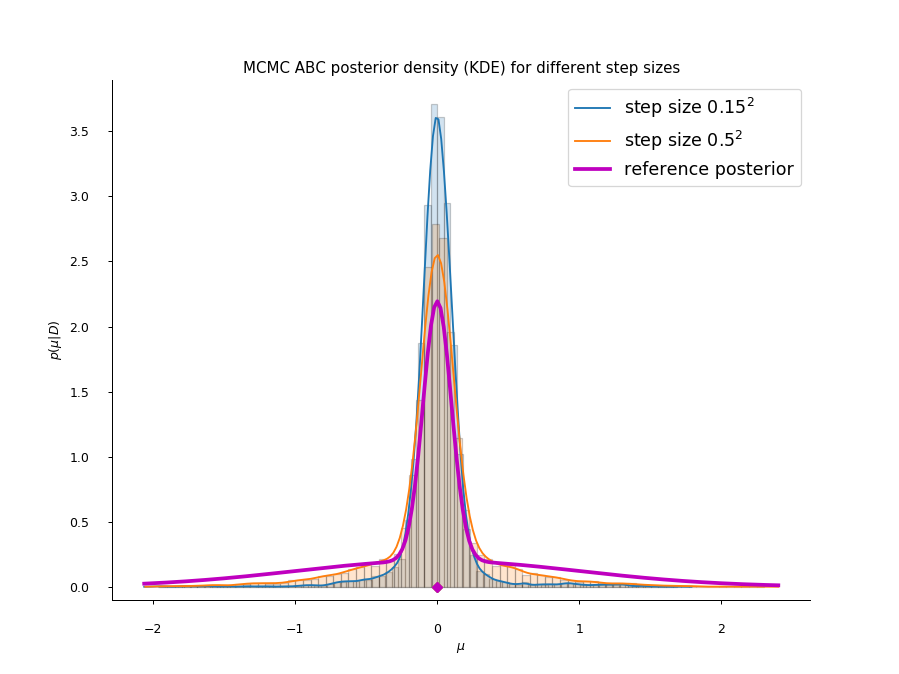

posterior mean: 0


[0.29687394658015087, 0.111451592407233]

In [54]:
mcmc_015 = pyabc.MCMCSampler.load(os.path.join(path_to_data, "ex03", "mcmc_10000_0_01_0_15.npy"))
mcmc_05 = pyabc.MCMCSampler.load(os.path.join(path_to_data, "ex03", "mcmc_10000_0_01_0_5.npy"))

legend = [r"step size $0.15^2$", r"step size $0.5^2$"]

plot_for_report(
    list_of_sampler = [mcmc_015, mcmc_05], 
    posterior=posterior, 
    posterior_mean=0,
    legend_text=legend, 
    title_text="MCMC ABC posterior density (KDE) for different step sizes", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex03_mcmc_abc_stepsize.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True,
    plot_hist=True,
    bins=80,
    edgecolor="k",
    alpha=0.2
)

In [56]:
mcmc_015.nr_iter

609811

In [57]:
mcmc_05.nr_iter

1141377

In [55]:
abs(0 - mcmc_015.Thetas.mean())

0.00077001924169393303

In [70]:
abs(0 - mcmc_05.Thetas.mean())

0.0017446437454710193

In [71]:
smc = pyabc.SMCSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0, verbosity=2)

In [72]:
smc.sample(nr_samples=10000, thresholds=np.linspace(2, 0.01, 6))
smc.save(os.path.join(path_to_data, "ex03", "smc_10000_0_01_6.npy"))

SMC sampler started with thresholds: [ 2.     1.602  1.204  0.806  0.408  0.01 ] and number of samples: 10000
Rejection sampler started with threshold: 2.0 and number of samples: 10000
Samples:    204 /  10000 (  2 %)- Threshold: 2.0000 - Iterations:       1000 - Acceptance rate: 0.204000 - Time:     0.04 s
Samples:    418 /  10000 (  4 %)- Threshold: 2.0000 - Iterations:       2000 - Acceptance rate: 0.209000 - Time:     0.07 s
Samples:    620 /  10000 (  6 %)- Threshold: 2.0000 - Iterations:       3000 - Acceptance rate: 0.206667 - Time:     0.09 s
Samples:    825 /  10000 (  8 %)- Threshold: 2.0000 - Iterations:       4000 - Acceptance rate: 0.206250 - Time:     0.12 s
Samples:   1018 /  10000 ( 10 %)- Threshold: 2.0000 - Iterations:       5000 - Acceptance rate: 0.203600 - Time:     0.14 s
Samples:   1232 /  10000 ( 12 %)- Threshold: 2.0000 - Iterations:       6000 - Acceptance rate: 0.205333 - Time:     0.17 s
Samples:   1438 /  10000 ( 14 %)- Threshold: 2.0000 - Iterations:      

Samples:   1030 /  10000 ( 10 %)- Threshold: 1.2040 - Iterations:      73000 - Acceptance rate: 0.136986 - Time:    21.48 s
Samples:   2332 /  10000 ( 23 %)- Threshold: 1.2040 - Iterations:      76000 - Acceptance rate: 0.131579 - Time:    24.42 s
Samples:   2764 /  10000 ( 28 %)- Threshold: 1.2040 - Iterations:      77000 - Acceptance rate: 0.129870 - Time:    25.36 s
Samples:   3633 /  10000 ( 36 %)- Threshold: 1.2040 - Iterations:      79000 - Acceptance rate: 0.126582 - Time:    27.15 s
Samples:   4906 /  10000 ( 49 %)- Threshold: 1.2040 - Iterations:      82000 - Acceptance rate: 0.121951 - Time:    29.80 s
Samples:   5743 /  10000 ( 57 %)- Threshold: 1.2040 - Iterations:      84000 - Acceptance rate: 0.119048 - Time:    31.65 s
Samples:   7047 /  10000 ( 70 %)- Threshold: 1.2040 - Iterations:      87000 - Acceptance rate: 0.114943 - Time:    34.50 s
Samples:   7483 /  10000 ( 75 %)- Threshold: 1.2040 - Iterations:      88000 - Acceptance rate: 0.113636 - Time:    35.46 s
Samples:

Samples:      8 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     174000 - Acceptance rate: 0.057471 - Time:   107.94 s
Samples:     12 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     175000 - Acceptance rate: 0.057143 - Time:   108.63 s
Samples:     19 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     176000 - Acceptance rate: 0.056818 - Time:   109.34 s
Samples:     29 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     177000 - Acceptance rate: 0.056497 - Time:   110.03 s
Samples:     38 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     178000 - Acceptance rate: 0.056180 - Time:   110.74 s
Samples:     43 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     179000 - Acceptance rate: 0.055866 - Time:   111.50 s
Samples:     48 /  10000 (  0 %)- Threshold: 0.0100 - Iterations:     180000 - Acceptance rate: 0.055556 - Time:   112.19 s
Samples:     53 /  10000 (  1 %)- Threshold: 0.0100 - Iterations:     181000 - Acceptance rate: 0.055249 - Time:   112.86 s
Samples:

Samples:    434 /  10000 (  4 %)- Threshold: 0.0100 - Iterations:     241000 - Acceptance rate: 0.041494 - Time:   157.84 s
Samples:    440 /  10000 (  4 %)- Threshold: 0.0100 - Iterations:     242000 - Acceptance rate: 0.041322 - Time:   158.53 s
Samples:    445 /  10000 (  4 %)- Threshold: 0.0100 - Iterations:     243000 - Acceptance rate: 0.041152 - Time:   159.22 s
Samples:    450 /  10000 (  4 %)- Threshold: 0.0100 - Iterations:     244000 - Acceptance rate: 0.040984 - Time:   159.91 s
Samples:    455 /  10000 (  5 %)- Threshold: 0.0100 - Iterations:     245000 - Acceptance rate: 0.040816 - Time:   160.60 s
Samples:    459 /  10000 (  5 %)- Threshold: 0.0100 - Iterations:     246000 - Acceptance rate: 0.040650 - Time:   161.39 s
Samples:    466 /  10000 (  5 %)- Threshold: 0.0100 - Iterations:     247000 - Acceptance rate: 0.040486 - Time:   162.25 s
Samples:    474 /  10000 (  5 %)- Threshold: 0.0100 - Iterations:     248000 - Acceptance rate: 0.040323 - Time:   163.10 s
Samples:

Samples:    801 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     308000 - Acceptance rate: 0.032468 - Time:   210.81 s
Samples:    806 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     309000 - Acceptance rate: 0.032362 - Time:   211.76 s
Samples:    809 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     310000 - Acceptance rate: 0.032258 - Time:   212.50 s
Samples:    815 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     311000 - Acceptance rate: 0.032154 - Time:   213.13 s
Samples:    821 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     312000 - Acceptance rate: 0.032051 - Time:   213.86 s
Samples:    828 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     313000 - Acceptance rate: 0.031949 - Time:   214.52 s
Samples:    834 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     314000 - Acceptance rate: 0.031847 - Time:   215.17 s
Samples:    840 /  10000 (  8 %)- Threshold: 0.0100 - Iterations:     315000 - Acceptance rate: 0.031746 - Time:   215.81 s
Samples:

Samples:   1193 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     375000 - Acceptance rate: 0.026667 - Time:   258.23 s
Samples:   1200 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     376000 - Acceptance rate: 0.026596 - Time:   258.92 s
Samples:   1205 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     377000 - Acceptance rate: 0.026525 - Time:   259.61 s
Samples:   1213 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     378000 - Acceptance rate: 0.026455 - Time:   260.51 s
Samples:   1222 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     379000 - Acceptance rate: 0.026385 - Time:   261.18 s
Samples:   1225 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     380000 - Acceptance rate: 0.026316 - Time:   261.93 s
Samples:   1232 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     381000 - Acceptance rate: 0.026247 - Time:   262.60 s
Samples:   1239 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     382000 - Acceptance rate: 0.026178 - Time:   263.25 s
Samples:

Samples:   1620 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     443000 - Acceptance rate: 0.022573 - Time:   307.03 s
Samples:   1630 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     444000 - Acceptance rate: 0.022523 - Time:   307.81 s
Samples:   1635 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     445000 - Acceptance rate: 0.022472 - Time:   308.49 s
Samples:   1639 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     446000 - Acceptance rate: 0.022422 - Time:   309.19 s
Samples:   1645 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     447000 - Acceptance rate: 0.022371 - Time:   309.87 s
Samples:   1650 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     448000 - Acceptance rate: 0.022321 - Time:   310.52 s
Samples:   1658 /  10000 ( 17 %)- Threshold: 0.0100 - Iterations:     449000 - Acceptance rate: 0.022272 - Time:   311.20 s
Samples:   1665 /  10000 ( 17 %)- Threshold: 0.0100 - Iterations:     450000 - Acceptance rate: 0.022222 - Time:   311.86 s
Samples:

Samples:   2020 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     510000 - Acceptance rate: 0.019608 - Time:   353.97 s
Samples:   2025 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     511000 - Acceptance rate: 0.019569 - Time:   354.63 s
Samples:   2029 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     512000 - Acceptance rate: 0.019531 - Time:   355.29 s
Samples:   2036 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     513000 - Acceptance rate: 0.019493 - Time:   355.94 s
Samples:   2039 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     514000 - Acceptance rate: 0.019455 - Time:   356.66 s
Samples:   2041 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     515000 - Acceptance rate: 0.019417 - Time:   357.55 s
Samples:   2045 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     516000 - Acceptance rate: 0.019380 - Time:   358.38 s
Samples:   2050 /  10000 ( 20 %)- Threshold: 0.0100 - Iterations:     517000 - Acceptance rate: 0.019342 - Time:   359.32 s
Samples:

Samples:   2421 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     577000 - Acceptance rate: 0.017331 - Time:   402.66 s
Samples:   2428 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     578000 - Acceptance rate: 0.017301 - Time:   403.47 s
Samples:   2432 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     579000 - Acceptance rate: 0.017271 - Time:   404.13 s
Samples:   2433 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     580000 - Acceptance rate: 0.017241 - Time:   404.82 s
Samples:   2440 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     581000 - Acceptance rate: 0.017212 - Time:   405.57 s
Samples:   2445 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     582000 - Acceptance rate: 0.017182 - Time:   406.25 s
Samples:   2450 /  10000 ( 24 %)- Threshold: 0.0100 - Iterations:     583000 - Acceptance rate: 0.017153 - Time:   406.90 s
Samples:   2454 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     584000 - Acceptance rate: 0.017123 - Time:   407.55 s
Samples:

Samples:   2832 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     644000 - Acceptance rate: 0.015528 - Time:   449.10 s
Samples:   2837 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     645000 - Acceptance rate: 0.015504 - Time:   449.82 s
Samples:   2842 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     646000 - Acceptance rate: 0.015480 - Time:   450.49 s
Samples:   2846 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     647000 - Acceptance rate: 0.015456 - Time:   451.12 s
Samples:   2850 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     648000 - Acceptance rate: 0.015432 - Time:   451.76 s
Samples:   2855 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     649000 - Acceptance rate: 0.015408 - Time:   452.39 s
Samples:   2857 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     650000 - Acceptance rate: 0.015385 - Time:   453.02 s
Samples:   2865 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     651000 - Acceptance rate: 0.015361 - Time:   453.65 s
Samples:

Samples:   3185 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     711000 - Acceptance rate: 0.014065 - Time:   493.61 s
Samples:   3192 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     712000 - Acceptance rate: 0.014045 - Time:   494.24 s
Samples:   3196 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     713000 - Acceptance rate: 0.014025 - Time:   494.91 s
Samples:   3201 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     714000 - Acceptance rate: 0.014006 - Time:   495.56 s
Samples:   3206 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     715000 - Acceptance rate: 0.013986 - Time:   496.23 s
Samples:   3215 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     716000 - Acceptance rate: 0.013966 - Time:   496.91 s
Samples:   3218 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     717000 - Acceptance rate: 0.013947 - Time:   497.61 s
Samples:   3224 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     718000 - Acceptance rate: 0.013928 - Time:   498.35 s
Samples:

Samples:   3600 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     779000 - Acceptance rate: 0.012837 - Time:   540.27 s
Samples:   3606 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     780000 - Acceptance rate: 0.012821 - Time:   540.98 s
Samples:   3611 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     781000 - Acceptance rate: 0.012804 - Time:   541.67 s
Samples:   3620 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     782000 - Acceptance rate: 0.012788 - Time:   542.38 s
Samples:   3624 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     783000 - Acceptance rate: 0.012771 - Time:   543.06 s
Samples:   3633 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     785000 - Acceptance rate: 0.012739 - Time:   544.43 s
Samples:   3639 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     786000 - Acceptance rate: 0.012723 - Time:   545.12 s
Samples:   3645 /  10000 ( 36 %)- Threshold: 0.0100 - Iterations:     787000 - Acceptance rate: 0.012706 - Time:   545.78 s
Samples:

Samples:   3986 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     848000 - Acceptance rate: 0.011792 - Time:   595.24 s
Samples:   3994 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     849000 - Acceptance rate: 0.011779 - Time:   596.13 s
Samples:   3999 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     850000 - Acceptance rate: 0.011765 - Time:   596.89 s
Samples:   4007 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     851000 - Acceptance rate: 0.011751 - Time:   598.01 s
Samples:   4013 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     852000 - Acceptance rate: 0.011737 - Time:   598.84 s
Samples:   4020 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     853000 - Acceptance rate: 0.011723 - Time:   599.51 s
Samples:   4026 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     854000 - Acceptance rate: 0.011710 - Time:   600.19 s
Samples:   4031 /  10000 ( 40 %)- Threshold: 0.0100 - Iterations:     855000 - Acceptance rate: 0.011696 - Time:   600.86 s
Samples:

Samples:   4405 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     915000 - Acceptance rate: 0.010929 - Time:   648.86 s
Samples:   4410 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     916000 - Acceptance rate: 0.010917 - Time:   649.54 s
Samples:   4416 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     917000 - Acceptance rate: 0.010905 - Time:   650.21 s
Samples:   4418 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     918000 - Acceptance rate: 0.010893 - Time:   650.99 s
Samples:   4424 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     919000 - Acceptance rate: 0.010881 - Time:   651.73 s
Samples:   4433 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     920000 - Acceptance rate: 0.010870 - Time:   652.37 s
Samples:   4438 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     921000 - Acceptance rate: 0.010858 - Time:   653.01 s
Samples:   4446 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:     922000 - Acceptance rate: 0.010846 - Time:   653.89 s
Samples:

Samples:   4803 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     982000 - Acceptance rate: 0.010183 - Time:   696.09 s
Samples:   4809 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     983000 - Acceptance rate: 0.010173 - Time:   696.77 s
Samples:   4813 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     984000 - Acceptance rate: 0.010163 - Time:   697.44 s
Samples:   4816 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     985000 - Acceptance rate: 0.010152 - Time:   698.14 s
Samples:   4821 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     986000 - Acceptance rate: 0.010142 - Time:   698.88 s
Samples:   4830 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     987000 - Acceptance rate: 0.010132 - Time:   699.60 s
Samples:   4836 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     988000 - Acceptance rate: 0.010121 - Time:   700.25 s
Samples:   4845 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:     989000 - Acceptance rate: 0.010111 - Time:   700.90 s
Samples:

Samples:   5193 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1049000 - Acceptance rate: 0.009533 - Time:   742.46 s
Samples:   5203 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1050000 - Acceptance rate: 0.009524 - Time:   743.14 s
Samples:   5211 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1051000 - Acceptance rate: 0.009515 - Time:   743.82 s
Samples:   5218 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1052000 - Acceptance rate: 0.009506 - Time:   744.50 s
Samples:   5223 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1053000 - Acceptance rate: 0.009497 - Time:   745.19 s
Samples:   5230 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1054000 - Acceptance rate: 0.009488 - Time:   745.87 s
Samples:   5239 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1055000 - Acceptance rate: 0.009479 - Time:   746.62 s
Samples:   5244 /  10000 ( 52 %)- Threshold: 0.0100 - Iterations:    1056000 - Acceptance rate: 0.009470 - Time:   747.32 s
Samples:

Samples:   5599 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1116000 - Acceptance rate: 0.008961 - Time:   786.87 s
Samples:   5605 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1117000 - Acceptance rate: 0.008953 - Time:   787.49 s
Samples:   5610 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1118000 - Acceptance rate: 0.008945 - Time:   788.11 s
Samples:   5613 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1119000 - Acceptance rate: 0.008937 - Time:   788.73 s
Samples:   5619 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1120000 - Acceptance rate: 0.008929 - Time:   789.35 s
Samples:   5627 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1121000 - Acceptance rate: 0.008921 - Time:   789.97 s
Samples:   5628 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1122000 - Acceptance rate: 0.008913 - Time:   790.59 s
Samples:   5633 /  10000 ( 56 %)- Threshold: 0.0100 - Iterations:    1123000 - Acceptance rate: 0.008905 - Time:   791.20 s
Samples:

Samples:   5945 /  10000 ( 59 %)- Threshold: 0.0100 - Iterations:    1183000 - Acceptance rate: 0.008453 - Time:   828.41 s
Samples:   5950 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1184000 - Acceptance rate: 0.008446 - Time:   829.03 s
Samples:   5953 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1185000 - Acceptance rate: 0.008439 - Time:   829.65 s
Samples:   5963 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1186000 - Acceptance rate: 0.008432 - Time:   830.28 s
Samples:   5969 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1187000 - Acceptance rate: 0.008425 - Time:   830.90 s
Samples:   5979 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1188000 - Acceptance rate: 0.008418 - Time:   831.53 s
Samples:   5983 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1189000 - Acceptance rate: 0.008410 - Time:   832.15 s
Samples:   5989 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1190000 - Acceptance rate: 0.008403 - Time:   832.77 s
Samples:

Samples:   6368 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1251000 - Acceptance rate: 0.007994 - Time:   870.91 s
Samples:   6379 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1252000 - Acceptance rate: 0.007987 - Time:   871.54 s
Samples:   6391 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1253000 - Acceptance rate: 0.007981 - Time:   872.16 s
Samples:   6397 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1254000 - Acceptance rate: 0.007974 - Time:   872.78 s
Samples:   6400 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1255000 - Acceptance rate: 0.007968 - Time:   873.40 s
Samples:   6407 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1256000 - Acceptance rate: 0.007962 - Time:   874.03 s
Samples:   6411 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1257000 - Acceptance rate: 0.007955 - Time:   874.66 s
Samples:   6413 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1258000 - Acceptance rate: 0.007949 - Time:   875.28 s
Samples:

Samples:   6754 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1318000 - Acceptance rate: 0.007587 - Time:   912.64 s
Samples:   6759 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1319000 - Acceptance rate: 0.007582 - Time:   913.26 s
Samples:   6763 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1320000 - Acceptance rate: 0.007576 - Time:   913.88 s
Samples:   6768 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1321000 - Acceptance rate: 0.007570 - Time:   914.50 s
Samples:   6772 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1322000 - Acceptance rate: 0.007564 - Time:   915.11 s
Samples:   6776 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1323000 - Acceptance rate: 0.007559 - Time:   915.73 s
Samples:   6777 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1324000 - Acceptance rate: 0.007553 - Time:   916.34 s
Samples:   6786 /  10000 ( 68 %)- Threshold: 0.0100 - Iterations:    1325000 - Acceptance rate: 0.007547 - Time:   916.96 s
Samples:

Samples:   7153 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1385000 - Acceptance rate: 0.007220 - Time:   954.29 s
Samples:   7155 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1386000 - Acceptance rate: 0.007215 - Time:   954.90 s
Samples:   7158 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1387000 - Acceptance rate: 0.007210 - Time:   955.52 s
Samples:   7163 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1388000 - Acceptance rate: 0.007205 - Time:   956.14 s
Samples:   7170 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1389000 - Acceptance rate: 0.007199 - Time:   956.78 s
Samples:   7173 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1390000 - Acceptance rate: 0.007194 - Time:   957.61 s
Samples:   7181 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1391000 - Acceptance rate: 0.007189 - Time:   958.27 s
Samples:   7195 /  10000 ( 72 %)- Threshold: 0.0100 - Iterations:    1393000 - Acceptance rate: 0.007179 - Time:   959.52 s
Samples:

Samples:   7548 /  10000 ( 75 %)- Threshold: 0.0100 - Iterations:    1453000 - Acceptance rate: 0.006882 - Time:   996.73 s
Samples:   7555 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1454000 - Acceptance rate: 0.006878 - Time:   997.34 s
Samples:   7562 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1455000 - Acceptance rate: 0.006873 - Time:   997.96 s
Samples:   7571 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1456000 - Acceptance rate: 0.006868 - Time:   998.58 s
Samples:   7582 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1457000 - Acceptance rate: 0.006863 - Time:   999.20 s
Samples:   7589 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1458000 - Acceptance rate: 0.006859 - Time:   999.82 s
Samples:   7597 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1459000 - Acceptance rate: 0.006854 - Time:  1000.44 s
Samples:   7599 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1460000 - Acceptance rate: 0.006849 - Time:  1001.06 s
Samples:

Samples:   7951 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1520000 - Acceptance rate: 0.006579 - Time:  1038.51 s
Samples:   7959 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1521000 - Acceptance rate: 0.006575 - Time:  1039.16 s
Samples:   7966 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1522000 - Acceptance rate: 0.006570 - Time:  1039.78 s
Samples:   7976 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1523000 - Acceptance rate: 0.006566 - Time:  1040.40 s
Samples:   7982 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1524000 - Acceptance rate: 0.006562 - Time:  1041.02 s
Samples:   7986 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1525000 - Acceptance rate: 0.006557 - Time:  1041.63 s
Samples:   7992 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1526000 - Acceptance rate: 0.006553 - Time:  1042.25 s
Samples:   7997 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1527000 - Acceptance rate: 0.006549 - Time:  1042.87 s
Samples:

Samples:   8320 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1587000 - Acceptance rate: 0.006301 - Time:  1081.34 s
Samples:   8325 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1588000 - Acceptance rate: 0.006297 - Time:  1081.96 s
Samples:   8329 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1589000 - Acceptance rate: 0.006293 - Time:  1082.59 s
Samples:   8334 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1590000 - Acceptance rate: 0.006289 - Time:  1083.21 s
Samples:   8343 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1591000 - Acceptance rate: 0.006285 - Time:  1083.84 s
Samples:   8347 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1592000 - Acceptance rate: 0.006281 - Time:  1084.46 s
Samples:   8353 /  10000 ( 84 %)- Threshold: 0.0100 - Iterations:    1593000 - Acceptance rate: 0.006277 - Time:  1085.09 s
Samples:   8358 /  10000 ( 84 %)- Threshold: 0.0100 - Iterations:    1594000 - Acceptance rate: 0.006274 - Time:  1085.71 s
Samples:

Samples:   8717 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1654000 - Acceptance rate: 0.006046 - Time:  1123.45 s
Samples:   8721 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1655000 - Acceptance rate: 0.006042 - Time:  1124.13 s
Samples:   8730 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1656000 - Acceptance rate: 0.006039 - Time:  1124.75 s
Samples:   8731 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1657000 - Acceptance rate: 0.006035 - Time:  1125.39 s
Samples:   8739 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1658000 - Acceptance rate: 0.006031 - Time:  1126.11 s
Samples:   8742 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1659000 - Acceptance rate: 0.006028 - Time:  1126.75 s
Samples:   8749 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1660000 - Acceptance rate: 0.006024 - Time:  1127.37 s
Samples:   8757 /  10000 ( 88 %)- Threshold: 0.0100 - Iterations:    1661000 - Acceptance rate: 0.006020 - Time:  1128.01 s
Samples:

Samples:   9093 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1721000 - Acceptance rate: 0.005811 - Time:  1165.61 s
Samples:   9099 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1722000 - Acceptance rate: 0.005807 - Time:  1166.23 s
Samples:   9106 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1723000 - Acceptance rate: 0.005804 - Time:  1166.85 s
Samples:   9112 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1724000 - Acceptance rate: 0.005800 - Time:  1167.47 s
Samples:   9118 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1725000 - Acceptance rate: 0.005797 - Time:  1168.10 s
Samples:   9128 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1726000 - Acceptance rate: 0.005794 - Time:  1168.73 s
Samples:   9130 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1727000 - Acceptance rate: 0.005790 - Time:  1169.34 s
Samples:   9136 /  10000 ( 91 %)- Threshold: 0.0100 - Iterations:    1728000 - Acceptance rate: 0.005787 - Time:  1169.97 s
Samples:

Samples:   9489 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1788000 - Acceptance rate: 0.005593 - Time:  1208.31 s
Samples:   9496 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1789000 - Acceptance rate: 0.005590 - Time:  1208.94 s
Samples:   9505 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1790000 - Acceptance rate: 0.005587 - Time:  1209.56 s
Samples:   9508 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1791000 - Acceptance rate: 0.005583 - Time:  1210.19 s
Samples:   9515 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1792000 - Acceptance rate: 0.005580 - Time:  1210.81 s
Samples:   9519 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1793000 - Acceptance rate: 0.005577 - Time:  1211.43 s
Samples:   9526 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1794000 - Acceptance rate: 0.005574 - Time:  1212.06 s
Samples:   9531 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    1795000 - Acceptance rate: 0.005571 - Time:  1212.69 s
Samples:

Samples:   9862 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1855000 - Acceptance rate: 0.005391 - Time:  1250.47 s
Samples:   9872 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1856000 - Acceptance rate: 0.005388 - Time:  1251.10 s
Samples:   9878 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1857000 - Acceptance rate: 0.005385 - Time:  1251.72 s
Samples:   9883 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1858000 - Acceptance rate: 0.005382 - Time:  1252.34 s
Samples:   9889 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1859000 - Acceptance rate: 0.005379 - Time:  1252.95 s
Samples:   9893 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1860000 - Acceptance rate: 0.005376 - Time:  1253.57 s
Samples:   9898 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1861000 - Acceptance rate: 0.005373 - Time:  1254.25 s
Samples:   9903 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    1862000 - Acceptance rate: 0.005371 - Time:  1254.89 s
Samples:

In [73]:
smc.sample(nr_samples=10000, thresholds=np.linspace(2, 0.01, 3))
smc.save(os.path.join(path_to_data, "ex03", "smc_10000_0_01_3.npy"))

SMC sampler started with thresholds: [ 2.     1.005  0.01 ] and number of samples: 10000
Rejection sampler started with threshold: 2.0 and number of samples: 10000
Samples:    182 /  10000 (  2 %)- Threshold: 2.0000 - Iterations:       1000 - Acceptance rate: 0.182000 - Time:     0.05 s
Samples:    383 /  10000 (  4 %)- Threshold: 2.0000 - Iterations:       2000 - Acceptance rate: 0.191500 - Time:     0.09 s
Samples:    587 /  10000 (  6 %)- Threshold: 2.0000 - Iterations:       3000 - Acceptance rate: 0.195667 - Time:     0.12 s
Samples:    782 /  10000 (  8 %)- Threshold: 2.0000 - Iterations:       4000 - Acceptance rate: 0.195500 - Time:     0.16 s
Samples:    980 /  10000 ( 10 %)- Threshold: 2.0000 - Iterations:       5000 - Acceptance rate: 0.196000 - Time:     0.20 s
Samples:   1174 /  10000 ( 12 %)- Threshold: 2.0000 - Iterations:       6000 - Acceptance rate: 0.195667 - Time:     0.25 s
Samples:   1367 /  10000 ( 14 %)- Threshold: 2.0000 - Iterations:       7000 - Acceptance ra

Samples:   4779 /  10000 ( 48 %)- Threshold: 1.0050 - Iterations:      66000 - Acceptance rate: 0.151515 - Time:    13.98 s
Samples:   5054 /  10000 ( 51 %)- Threshold: 1.0050 - Iterations:      67000 - Acceptance rate: 0.149254 - Time:    14.75 s
Samples:   5371 /  10000 ( 54 %)- Threshold: 1.0050 - Iterations:      68000 - Acceptance rate: 0.147059 - Time:    15.57 s
Samples:   5676 /  10000 ( 57 %)- Threshold: 1.0050 - Iterations:      69000 - Acceptance rate: 0.144928 - Time:    16.36 s
Samples:   5998 /  10000 ( 60 %)- Threshold: 1.0050 - Iterations:      70000 - Acceptance rate: 0.142857 - Time:    17.14 s
Samples:   6632 /  10000 ( 66 %)- Threshold: 1.0050 - Iterations:      72000 - Acceptance rate: 0.138889 - Time:    18.69 s
Samples:   6956 /  10000 ( 70 %)- Threshold: 1.0050 - Iterations:      73000 - Acceptance rate: 0.136986 - Time:    19.47 s
Samples:   7261 /  10000 ( 73 %)- Threshold: 1.0050 - Iterations:      74000 - Acceptance rate: 0.135135 - Time:    20.24 s
Samples:

Samples:    254 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     134000 - Acceptance rate: 0.074627 - Time:    58.96 s
Samples:    260 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     135000 - Acceptance rate: 0.074074 - Time:    59.58 s
Samples:    264 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     136000 - Acceptance rate: 0.073529 - Time:    60.21 s
Samples:    267 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     137000 - Acceptance rate: 0.072993 - Time:    60.82 s
Samples:    269 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     138000 - Acceptance rate: 0.072464 - Time:    61.43 s
Samples:    272 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     139000 - Acceptance rate: 0.071942 - Time:    62.04 s
Samples:    278 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     140000 - Acceptance rate: 0.071429 - Time:    62.68 s
Samples:    283 /  10000 (  3 %)- Threshold: 0.0100 - Iterations:     141000 - Acceptance rate: 0.070922 - Time:    63.30 s
Samples:

Samples:    563 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     201000 - Acceptance rate: 0.049751 - Time:   100.38 s
Samples:    569 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     202000 - Acceptance rate: 0.049505 - Time:   101.02 s
Samples:    570 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     203000 - Acceptance rate: 0.049261 - Time:   101.63 s
Samples:    574 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     204000 - Acceptance rate: 0.049020 - Time:   102.31 s
Samples:    588 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     206000 - Acceptance rate: 0.048544 - Time:   103.56 s
Samples:    592 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     207000 - Acceptance rate: 0.048309 - Time:   104.17 s
Samples:    594 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     208000 - Acceptance rate: 0.048077 - Time:   104.78 s
Samples:    601 /  10000 (  6 %)- Threshold: 0.0100 - Iterations:     209000 - Acceptance rate: 0.047847 - Time:   105.39 s
Samples:

Samples:    898 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     269000 - Acceptance rate: 0.037175 - Time:   142.49 s
Samples:    902 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     270000 - Acceptance rate: 0.037037 - Time:   143.11 s
Samples:    905 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     271000 - Acceptance rate: 0.036900 - Time:   143.73 s
Samples:    905 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     272000 - Acceptance rate: 0.036765 - Time:   144.34 s
Samples:    906 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     273000 - Acceptance rate: 0.036630 - Time:   144.95 s
Samples:    913 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     274000 - Acceptance rate: 0.036496 - Time:   145.58 s
Samples:    918 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     275000 - Acceptance rate: 0.036364 - Time:   146.19 s
Samples:    923 /  10000 (  9 %)- Threshold: 0.0100 - Iterations:     276000 - Acceptance rate: 0.036232 - Time:   146.81 s
Samples:

Samples:   1203 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     336000 - Acceptance rate: 0.029762 - Time:   184.04 s
Samples:   1206 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     337000 - Acceptance rate: 0.029674 - Time:   184.65 s
Samples:   1209 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     338000 - Acceptance rate: 0.029586 - Time:   185.26 s
Samples:   1216 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     339000 - Acceptance rate: 0.029499 - Time:   185.87 s
Samples:   1219 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     340000 - Acceptance rate: 0.029412 - Time:   186.48 s
Samples:   1225 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     341000 - Acceptance rate: 0.029326 - Time:   187.10 s
Samples:   1227 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     342000 - Acceptance rate: 0.029240 - Time:   187.70 s
Samples:   1237 /  10000 ( 12 %)- Threshold: 0.0100 - Iterations:     343000 - Acceptance rate: 0.029155 - Time:   188.32 s
Samples:

Samples:   1542 /  10000 ( 15 %)- Threshold: 0.0100 - Iterations:     403000 - Acceptance rate: 0.024814 - Time:   225.80 s
Samples:   1548 /  10000 ( 15 %)- Threshold: 0.0100 - Iterations:     404000 - Acceptance rate: 0.024752 - Time:   226.42 s
Samples:   1551 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     405000 - Acceptance rate: 0.024691 - Time:   227.04 s
Samples:   1560 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     406000 - Acceptance rate: 0.024631 - Time:   227.66 s
Samples:   1566 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     407000 - Acceptance rate: 0.024570 - Time:   228.27 s
Samples:   1573 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     408000 - Acceptance rate: 0.024510 - Time:   228.88 s
Samples:   1576 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     409000 - Acceptance rate: 0.024450 - Time:   229.50 s
Samples:   1580 /  10000 ( 16 %)- Threshold: 0.0100 - Iterations:     410000 - Acceptance rate: 0.024390 - Time:   230.11 s
Samples:

Samples:   1875 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     470000 - Acceptance rate: 0.021277 - Time:   267.18 s
Samples:   1879 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     471000 - Acceptance rate: 0.021231 - Time:   267.79 s
Samples:   1888 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     472000 - Acceptance rate: 0.021186 - Time:   268.41 s
Samples:   1892 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     473000 - Acceptance rate: 0.021142 - Time:   269.02 s
Samples:   1899 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     474000 - Acceptance rate: 0.021097 - Time:   269.63 s
Samples:   1905 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     475000 - Acceptance rate: 0.021053 - Time:   270.25 s
Samples:   1912 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     476000 - Acceptance rate: 0.021008 - Time:   270.87 s
Samples:   1914 /  10000 ( 19 %)- Threshold: 0.0100 - Iterations:     477000 - Acceptance rate: 0.020964 - Time:   271.48 s
Samples:

Samples:   2216 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     538000 - Acceptance rate: 0.018587 - Time:   309.30 s
Samples:   2221 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     539000 - Acceptance rate: 0.018553 - Time:   309.92 s
Samples:   2229 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     540000 - Acceptance rate: 0.018519 - Time:   310.53 s
Samples:   2234 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     541000 - Acceptance rate: 0.018484 - Time:   311.14 s
Samples:   2238 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     542000 - Acceptance rate: 0.018450 - Time:   311.76 s
Samples:   2242 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     543000 - Acceptance rate: 0.018416 - Time:   312.37 s
Samples:   2249 /  10000 ( 22 %)- Threshold: 0.0100 - Iterations:     544000 - Acceptance rate: 0.018382 - Time:   313.00 s
Samples:   2255 /  10000 ( 23 %)- Threshold: 0.0100 - Iterations:     545000 - Acceptance rate: 0.018349 - Time:   313.62 s
Samples:

Samples:   2529 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     605000 - Acceptance rate: 0.016529 - Time:   350.99 s
Samples:   2533 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     606000 - Acceptance rate: 0.016502 - Time:   351.61 s
Samples:   2536 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     607000 - Acceptance rate: 0.016474 - Time:   352.22 s
Samples:   2541 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     608000 - Acceptance rate: 0.016447 - Time:   352.83 s
Samples:   2547 /  10000 ( 25 %)- Threshold: 0.0100 - Iterations:     609000 - Acceptance rate: 0.016420 - Time:   353.45 s
Samples:   2550 /  10000 ( 26 %)- Threshold: 0.0100 - Iterations:     610000 - Acceptance rate: 0.016393 - Time:   354.08 s
Samples:   2556 /  10000 ( 26 %)- Threshold: 0.0100 - Iterations:     611000 - Acceptance rate: 0.016367 - Time:   354.71 s
Samples:   2563 /  10000 ( 26 %)- Threshold: 0.0100 - Iterations:     612000 - Acceptance rate: 0.016340 - Time:   355.33 s
Samples:

Samples:   2844 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     672000 - Acceptance rate: 0.014881 - Time:   392.35 s
Samples:   2846 /  10000 ( 28 %)- Threshold: 0.0100 - Iterations:     673000 - Acceptance rate: 0.014859 - Time:   392.97 s
Samples:   2851 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     674000 - Acceptance rate: 0.014837 - Time:   393.58 s
Samples:   2854 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     675000 - Acceptance rate: 0.014815 - Time:   394.20 s
Samples:   2862 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     676000 - Acceptance rate: 0.014793 - Time:   394.81 s
Samples:   2867 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     677000 - Acceptance rate: 0.014771 - Time:   395.43 s
Samples:   2873 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     678000 - Acceptance rate: 0.014749 - Time:   396.04 s
Samples:   2879 /  10000 ( 29 %)- Threshold: 0.0100 - Iterations:     679000 - Acceptance rate: 0.014728 - Time:   396.66 s
Samples:

Samples:   3181 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     740000 - Acceptance rate: 0.013514 - Time:   434.50 s
Samples:   3186 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     741000 - Acceptance rate: 0.013495 - Time:   435.12 s
Samples:   3188 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     742000 - Acceptance rate: 0.013477 - Time:   435.75 s
Samples:   3195 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     743000 - Acceptance rate: 0.013459 - Time:   436.37 s
Samples:   3200 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     744000 - Acceptance rate: 0.013441 - Time:   436.98 s
Samples:   3202 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     745000 - Acceptance rate: 0.013423 - Time:   437.59 s
Samples:   3204 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     746000 - Acceptance rate: 0.013405 - Time:   438.20 s
Samples:   3208 /  10000 ( 32 %)- Threshold: 0.0100 - Iterations:     747000 - Acceptance rate: 0.013387 - Time:   438.81 s
Samples:

Samples:   3493 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     808000 - Acceptance rate: 0.012376 - Time:   476.63 s
Samples:   3497 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     809000 - Acceptance rate: 0.012361 - Time:   477.24 s
Samples:   3506 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     810000 - Acceptance rate: 0.012346 - Time:   477.87 s
Samples:   3509 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     811000 - Acceptance rate: 0.012330 - Time:   478.48 s
Samples:   3511 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     812000 - Acceptance rate: 0.012315 - Time:   479.09 s
Samples:   3519 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     813000 - Acceptance rate: 0.012300 - Time:   479.70 s
Samples:   3526 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     814000 - Acceptance rate: 0.012285 - Time:   480.32 s
Samples:   3527 /  10000 ( 35 %)- Threshold: 0.0100 - Iterations:     815000 - Acceptance rate: 0.012270 - Time:   480.93 s
Samples:

Samples:   3804 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     875000 - Acceptance rate: 0.011429 - Time:   518.02 s
Samples:   3806 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     876000 - Acceptance rate: 0.011416 - Time:   518.67 s
Samples:   3810 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     877000 - Acceptance rate: 0.011403 - Time:   519.31 s
Samples:   3815 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     878000 - Acceptance rate: 0.011390 - Time:   519.94 s
Samples:   3818 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     879000 - Acceptance rate: 0.011377 - Time:   520.59 s
Samples:   3822 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     880000 - Acceptance rate: 0.011364 - Time:   521.25 s
Samples:   3828 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     881000 - Acceptance rate: 0.011351 - Time:   522.03 s
Samples:   3831 /  10000 ( 38 %)- Threshold: 0.0100 - Iterations:     882000 - Acceptance rate: 0.011338 - Time:   522.75 s
Samples:

Samples:   4111 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     942000 - Acceptance rate: 0.010616 - Time:   564.81 s
Samples:   4117 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     943000 - Acceptance rate: 0.010604 - Time:   565.45 s
Samples:   4125 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     944000 - Acceptance rate: 0.010593 - Time:   566.11 s
Samples:   4129 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     945000 - Acceptance rate: 0.010582 - Time:   566.76 s
Samples:   4133 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     946000 - Acceptance rate: 0.010571 - Time:   567.45 s
Samples:   4139 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     947000 - Acceptance rate: 0.010560 - Time:   568.13 s
Samples:   4141 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     948000 - Acceptance rate: 0.010549 - Time:   568.84 s
Samples:   4143 /  10000 ( 41 %)- Threshold: 0.0100 - Iterations:     949000 - Acceptance rate: 0.010537 - Time:   569.50 s
Samples:

Samples:   4431 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:    1010000 - Acceptance rate: 0.009901 - Time:   608.00 s
Samples:   4437 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:    1011000 - Acceptance rate: 0.009891 - Time:   608.62 s
Samples:   4440 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:    1012000 - Acceptance rate: 0.009881 - Time:   609.23 s
Samples:   4446 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:    1013000 - Acceptance rate: 0.009872 - Time:   609.87 s
Samples:   4450 /  10000 ( 44 %)- Threshold: 0.0100 - Iterations:    1014000 - Acceptance rate: 0.009862 - Time:   610.48 s
Samples:   4456 /  10000 ( 45 %)- Threshold: 0.0100 - Iterations:    1015000 - Acceptance rate: 0.009852 - Time:   611.10 s
Samples:   4459 /  10000 ( 45 %)- Threshold: 0.0100 - Iterations:    1016000 - Acceptance rate: 0.009843 - Time:   611.73 s
Samples:   4462 /  10000 ( 45 %)- Threshold: 0.0100 - Iterations:    1017000 - Acceptance rate: 0.009833 - Time:   612.35 s
Samples:

Samples:   4772 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1077000 - Acceptance rate: 0.009285 - Time:   649.95 s
Samples:   4776 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1078000 - Acceptance rate: 0.009276 - Time:   650.57 s
Samples:   4781 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1079000 - Acceptance rate: 0.009268 - Time:   651.19 s
Samples:   4792 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1080000 - Acceptance rate: 0.009259 - Time:   651.81 s
Samples:   4797 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1081000 - Acceptance rate: 0.009251 - Time:   652.42 s
Samples:   4803 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1082000 - Acceptance rate: 0.009242 - Time:   653.05 s
Samples:   4805 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1083000 - Acceptance rate: 0.009234 - Time:   653.67 s
Samples:   4810 /  10000 ( 48 %)- Threshold: 0.0100 - Iterations:    1084000 - Acceptance rate: 0.009225 - Time:   654.39 s
Samples:

Samples:   5092 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1144000 - Acceptance rate: 0.008741 - Time:   691.88 s
Samples:   5101 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1145000 - Acceptance rate: 0.008734 - Time:   692.51 s
Samples:   5106 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1146000 - Acceptance rate: 0.008726 - Time:   693.13 s
Samples:   5110 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1147000 - Acceptance rate: 0.008718 - Time:   693.75 s
Samples:   5117 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1148000 - Acceptance rate: 0.008711 - Time:   694.37 s
Samples:   5124 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1149000 - Acceptance rate: 0.008703 - Time:   695.00 s
Samples:   5126 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1150000 - Acceptance rate: 0.008696 - Time:   695.62 s
Samples:   5130 /  10000 ( 51 %)- Threshold: 0.0100 - Iterations:    1151000 - Acceptance rate: 0.008688 - Time:   696.25 s
Samples:

Samples:   5409 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1211000 - Acceptance rate: 0.008258 - Time:   733.84 s
Samples:   5411 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1212000 - Acceptance rate: 0.008251 - Time:   734.45 s
Samples:   5417 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1213000 - Acceptance rate: 0.008244 - Time:   735.10 s
Samples:   5419 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1214000 - Acceptance rate: 0.008237 - Time:   735.72 s
Samples:   5420 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1215000 - Acceptance rate: 0.008230 - Time:   736.37 s
Samples:   5428 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1216000 - Acceptance rate: 0.008224 - Time:   737.00 s
Samples:   5429 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1217000 - Acceptance rate: 0.008217 - Time:   737.62 s
Samples:   5439 /  10000 ( 54 %)- Threshold: 0.0100 - Iterations:    1218000 - Acceptance rate: 0.008210 - Time:   738.25 s
Samples:

Samples:   5689 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1278000 - Acceptance rate: 0.007825 - Time:   775.78 s
Samples:   5691 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1279000 - Acceptance rate: 0.007819 - Time:   776.42 s
Samples:   5694 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1280000 - Acceptance rate: 0.007812 - Time:   777.05 s
Samples:   5698 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1281000 - Acceptance rate: 0.007806 - Time:   777.66 s
Samples:   5702 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1282000 - Acceptance rate: 0.007800 - Time:   778.29 s
Samples:   5708 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1283000 - Acceptance rate: 0.007794 - Time:   778.91 s
Samples:   5713 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1284000 - Acceptance rate: 0.007788 - Time:   779.54 s
Samples:   5722 /  10000 ( 57 %)- Threshold: 0.0100 - Iterations:    1285000 - Acceptance rate: 0.007782 - Time:   780.16 s
Samples:

Samples:   6013 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1345000 - Acceptance rate: 0.007435 - Time:   817.60 s
Samples:   6020 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1346000 - Acceptance rate: 0.007429 - Time:   818.24 s
Samples:   6027 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1347000 - Acceptance rate: 0.007424 - Time:   818.86 s
Samples:   6030 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1348000 - Acceptance rate: 0.007418 - Time:   819.48 s
Samples:   6033 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1349000 - Acceptance rate: 0.007413 - Time:   820.10 s
Samples:   6039 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1350000 - Acceptance rate: 0.007407 - Time:   820.84 s
Samples:   6045 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1351000 - Acceptance rate: 0.007402 - Time:   821.49 s
Samples:   6050 /  10000 ( 60 %)- Threshold: 0.0100 - Iterations:    1352000 - Acceptance rate: 0.007396 - Time:   822.11 s
Samples:

Samples:   6366 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1413000 - Acceptance rate: 0.007077 - Time:   860.20 s
Samples:   6370 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1414000 - Acceptance rate: 0.007072 - Time:   860.82 s
Samples:   6373 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1415000 - Acceptance rate: 0.007067 - Time:   861.44 s
Samples:   6377 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1416000 - Acceptance rate: 0.007062 - Time:   862.06 s
Samples:   6380 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1417000 - Acceptance rate: 0.007057 - Time:   862.74 s
Samples:   6387 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1418000 - Acceptance rate: 0.007052 - Time:   863.42 s
Samples:   6396 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1419000 - Acceptance rate: 0.007047 - Time:   864.09 s
Samples:   6401 /  10000 ( 64 %)- Threshold: 0.0100 - Iterations:    1420000 - Acceptance rate: 0.007042 - Time:   864.73 s
Samples:

Samples:   6684 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1480000 - Acceptance rate: 0.006757 - Time:   902.64 s
Samples:   6687 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1481000 - Acceptance rate: 0.006752 - Time:   903.25 s
Samples:   6697 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1482000 - Acceptance rate: 0.006748 - Time:   903.86 s
Samples:   6706 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1483000 - Acceptance rate: 0.006743 - Time:   904.48 s
Samples:   6710 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1484000 - Acceptance rate: 0.006739 - Time:   905.09 s
Samples:   6714 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1485000 - Acceptance rate: 0.006734 - Time:   905.69 s
Samples:   6721 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1486000 - Acceptance rate: 0.006729 - Time:   906.32 s
Samples:   6729 /  10000 ( 67 %)- Threshold: 0.0100 - Iterations:    1487000 - Acceptance rate: 0.006725 - Time:   906.93 s
Samples:

Samples:   7022 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1547000 - Acceptance rate: 0.006464 - Time:   944.32 s
Samples:   7026 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1548000 - Acceptance rate: 0.006460 - Time:   944.93 s
Samples:   7029 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1549000 - Acceptance rate: 0.006456 - Time:   945.54 s
Samples:   7034 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1550000 - Acceptance rate: 0.006452 - Time:   946.17 s
Samples:   7038 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1551000 - Acceptance rate: 0.006447 - Time:   946.79 s
Samples:   7042 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1552000 - Acceptance rate: 0.006443 - Time:   947.41 s
Samples:   7046 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1553000 - Acceptance rate: 0.006439 - Time:   948.02 s
Samples:   7049 /  10000 ( 70 %)- Threshold: 0.0100 - Iterations:    1554000 - Acceptance rate: 0.006435 - Time:   948.63 s
Samples:

Samples:   7339 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1614000 - Acceptance rate: 0.006196 - Time:   985.75 s
Samples:   7340 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1615000 - Acceptance rate: 0.006192 - Time:   986.38 s
Samples:   7342 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1616000 - Acceptance rate: 0.006188 - Time:   986.99 s
Samples:   7345 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1617000 - Acceptance rate: 0.006184 - Time:   987.60 s
Samples:   7346 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1618000 - Acceptance rate: 0.006180 - Time:   988.22 s
Samples:   7348 /  10000 ( 73 %)- Threshold: 0.0100 - Iterations:    1619000 - Acceptance rate: 0.006177 - Time:   988.84 s
Samples:   7351 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:    1620000 - Acceptance rate: 0.006173 - Time:   989.46 s
Samples:   7354 /  10000 ( 74 %)- Threshold: 0.0100 - Iterations:    1621000 - Acceptance rate: 0.006169 - Time:   990.08 s
Samples:

Samples:   7627 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1681000 - Acceptance rate: 0.005949 - Time:  1027.90 s
Samples:   7632 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1682000 - Acceptance rate: 0.005945 - Time:  1028.52 s
Samples:   7639 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1683000 - Acceptance rate: 0.005942 - Time:  1029.14 s
Samples:   7642 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1684000 - Acceptance rate: 0.005938 - Time:  1029.75 s
Samples:   7646 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1685000 - Acceptance rate: 0.005935 - Time:  1030.36 s
Samples:   7650 /  10000 ( 76 %)- Threshold: 0.0100 - Iterations:    1686000 - Acceptance rate: 0.005931 - Time:  1030.98 s
Samples:   7651 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:    1687000 - Acceptance rate: 0.005928 - Time:  1031.60 s
Samples:   7656 /  10000 ( 77 %)- Threshold: 0.0100 - Iterations:    1688000 - Acceptance rate: 0.005924 - Time:  1032.21 s
Samples:

Samples:   7928 /  10000 ( 79 %)- Threshold: 0.0100 - Iterations:    1748000 - Acceptance rate: 0.005721 - Time:  1069.43 s
Samples:   7932 /  10000 ( 79 %)- Threshold: 0.0100 - Iterations:    1749000 - Acceptance rate: 0.005718 - Time:  1070.05 s
Samples:   7936 /  10000 ( 79 %)- Threshold: 0.0100 - Iterations:    1750000 - Acceptance rate: 0.005714 - Time:  1070.66 s
Samples:   7938 /  10000 ( 79 %)- Threshold: 0.0100 - Iterations:    1751000 - Acceptance rate: 0.005711 - Time:  1071.32 s
Samples:   7948 /  10000 ( 79 %)- Threshold: 0.0100 - Iterations:    1753000 - Acceptance rate: 0.005705 - Time:  1072.56 s
Samples:   7955 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1754000 - Acceptance rate: 0.005701 - Time:  1073.17 s
Samples:   7960 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1755000 - Acceptance rate: 0.005698 - Time:  1073.79 s
Samples:   7968 /  10000 ( 80 %)- Threshold: 0.0100 - Iterations:    1756000 - Acceptance rate: 0.005695 - Time:  1074.42 s
Samples:

Samples:   8266 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1816000 - Acceptance rate: 0.005507 - Time:  1111.48 s
Samples:   8270 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1817000 - Acceptance rate: 0.005504 - Time:  1112.09 s
Samples:   8276 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1818000 - Acceptance rate: 0.005501 - Time:  1112.71 s
Samples:   8280 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1819000 - Acceptance rate: 0.005498 - Time:  1113.32 s
Samples:   8287 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1820000 - Acceptance rate: 0.005495 - Time:  1113.93 s
Samples:   8293 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1821000 - Acceptance rate: 0.005491 - Time:  1114.55 s
Samples:   8300 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1822000 - Acceptance rate: 0.005488 - Time:  1115.20 s
Samples:   8304 /  10000 ( 83 %)- Threshold: 0.0100 - Iterations:    1823000 - Acceptance rate: 0.005485 - Time:  1115.81 s
Samples:

Samples:   8622 /  10000 ( 86 %)- Threshold: 0.0100 - Iterations:    1883000 - Acceptance rate: 0.005311 - Time:  1153.34 s
Samples:   8630 /  10000 ( 86 %)- Threshold: 0.0100 - Iterations:    1884000 - Acceptance rate: 0.005308 - Time:  1153.96 s
Samples:   8636 /  10000 ( 86 %)- Threshold: 0.0100 - Iterations:    1885000 - Acceptance rate: 0.005305 - Time:  1154.57 s
Samples:   8640 /  10000 ( 86 %)- Threshold: 0.0100 - Iterations:    1886000 - Acceptance rate: 0.005302 - Time:  1155.20 s
Samples:   8648 /  10000 ( 86 %)- Threshold: 0.0100 - Iterations:    1887000 - Acceptance rate: 0.005299 - Time:  1155.83 s
Samples:   8653 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1888000 - Acceptance rate: 0.005297 - Time:  1156.46 s
Samples:   8661 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1889000 - Acceptance rate: 0.005294 - Time:  1157.09 s
Samples:   8665 /  10000 ( 87 %)- Threshold: 0.0100 - Iterations:    1890000 - Acceptance rate: 0.005291 - Time:  1157.70 s
Samples:

Samples:   8925 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1950000 - Acceptance rate: 0.005128 - Time:  1194.93 s
Samples:   8930 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1951000 - Acceptance rate: 0.005126 - Time:  1195.55 s
Samples:   8933 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1952000 - Acceptance rate: 0.005123 - Time:  1196.16 s
Samples:   8937 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1953000 - Acceptance rate: 0.005120 - Time:  1196.77 s
Samples:   8944 /  10000 ( 89 %)- Threshold: 0.0100 - Iterations:    1954000 - Acceptance rate: 0.005118 - Time:  1197.38 s
Samples:   8951 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:    1955000 - Acceptance rate: 0.005115 - Time:  1198.00 s
Samples:   8959 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:    1956000 - Acceptance rate: 0.005112 - Time:  1198.61 s
Samples:   8967 /  10000 ( 90 %)- Threshold: 0.0100 - Iterations:    1957000 - Acceptance rate: 0.005110 - Time:  1199.23 s
Samples:

Samples:   9242 /  10000 ( 92 %)- Threshold: 0.0100 - Iterations:    2017000 - Acceptance rate: 0.004958 - Time:  1236.36 s
Samples:   9244 /  10000 ( 92 %)- Threshold: 0.0100 - Iterations:    2018000 - Acceptance rate: 0.004955 - Time:  1237.00 s
Samples:   9245 /  10000 ( 92 %)- Threshold: 0.0100 - Iterations:    2019000 - Acceptance rate: 0.004953 - Time:  1237.71 s
Samples:   9249 /  10000 ( 92 %)- Threshold: 0.0100 - Iterations:    2020000 - Acceptance rate: 0.004950 - Time:  1238.51 s
Samples:   9254 /  10000 ( 93 %)- Threshold: 0.0100 - Iterations:    2021000 - Acceptance rate: 0.004948 - Time:  1239.31 s
Samples:   9256 /  10000 ( 93 %)- Threshold: 0.0100 - Iterations:    2022000 - Acceptance rate: 0.004946 - Time:  1240.14 s
Samples:   9259 /  10000 ( 93 %)- Threshold: 0.0100 - Iterations:    2023000 - Acceptance rate: 0.004943 - Time:  1240.84 s
Samples:   9262 /  10000 ( 93 %)- Threshold: 0.0100 - Iterations:    2024000 - Acceptance rate: 0.004941 - Time:  1241.64 s
Samples:

Samples:   9546 /  10000 ( 95 %)- Threshold: 0.0100 - Iterations:    2084000 - Acceptance rate: 0.004798 - Time:  1286.34 s
Samples:   9551 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2085000 - Acceptance rate: 0.004796 - Time:  1286.97 s
Samples:   9553 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2086000 - Acceptance rate: 0.004794 - Time:  1287.58 s
Samples:   9558 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2087000 - Acceptance rate: 0.004792 - Time:  1288.30 s
Samples:   9561 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2088000 - Acceptance rate: 0.004789 - Time:  1289.03 s
Samples:   9566 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2089000 - Acceptance rate: 0.004787 - Time:  1289.73 s
Samples:   9569 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2090000 - Acceptance rate: 0.004785 - Time:  1290.45 s
Samples:   9578 /  10000 ( 96 %)- Threshold: 0.0100 - Iterations:    2091000 - Acceptance rate: 0.004782 - Time:  1291.08 s
Samples:

Samples:   9877 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2151000 - Acceptance rate: 0.004649 - Time:  1335.08 s
Samples:   9879 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2152000 - Acceptance rate: 0.004647 - Time:  1335.74 s
Samples:   9884 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2153000 - Acceptance rate: 0.004645 - Time:  1336.38 s
Samples:   9889 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2154000 - Acceptance rate: 0.004643 - Time:  1337.15 s
Samples:   9899 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2155000 - Acceptance rate: 0.004640 - Time:  1337.92 s
Samples:   9906 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2156000 - Acceptance rate: 0.004638 - Time:  1338.56 s
Samples:   9910 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2157000 - Acceptance rate: 0.004636 - Time:  1339.29 s
Samples:   9914 /  10000 ( 99 %)- Threshold: 0.0100 - Iterations:    2158000 - Acceptance rate: 0.004634 - Time:  1340.05 s
Samples:

<IPython.core.display.Javascript object>


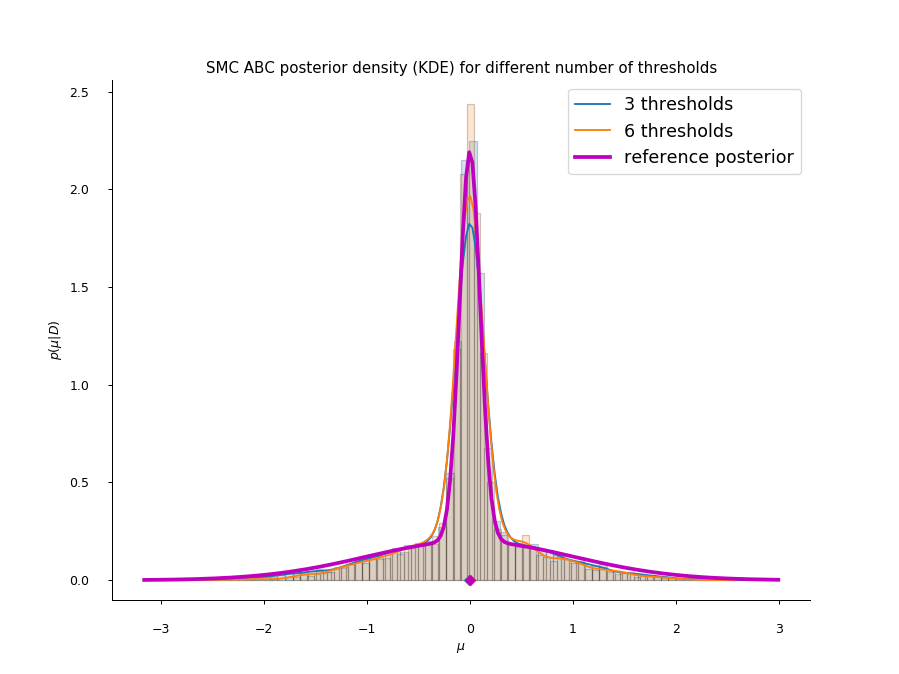

posterior mean: 0


[0.036688860423621752, 0.050662315447381388]

In [58]:
smc_3 = pyabc.SMCSampler.load(os.path.join(path_to_data, "ex03", "smc_10000_0_01_3.npy"))
smc_6 = pyabc.SMCSampler.load(os.path.join(path_to_data, "ex03", "smc_10000_0_01_6.npy"))

legend = [r"3 thresholds", r"6 thresholds"]

plot_for_report(
    list_of_sampler = [smc_3, smc_6], 
    posterior=posterior, 
    posterior_mean=0,
    legend_text=legend, 
    title_text="SMC ABC posterior density (KDE) for different number of thresholds", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex03_smc_abc.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True,
    plot_hist=True,
    bins=80,
    edgecolor="k",
    alpha=0.2
)

In [59]:
smc_3.nr_iter

2175425

In [60]:
smc_6.nr_iter

1876087

In [76]:
abs(smc_3.Thetas.mean() - 0)

0.01054010467444179

In [77]:
abs(smc_6.Thetas.mean() - 0)

0.0023815591990320457